In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [1]:
def myround(x, base=5):
    return base * round(float(x) / base)

In [6]:
systems    = pd.read_csv("systems.csv",encoding='latin-1')
facilities = pd.read_csv("facilities.csv",encoding='latin-1')

display(systems.head())
display(facilities.head())

,system,inmate_tests,total_inmate_cases,total_inmate_deaths,latest_inmate_population,max_inmate_population_2020,total_officer_cases,total_officer_deaths
0,Alabama,15505.0,1601,64,19144.0,21900.0,1019.0,3.0
1,Alaska,27756.0,2428,5,5011.0,5143.0,85.0,0.0
2,Arizona,43652.0,12229,44,38248.0,41674.0,2739.0,0.0
3,Arkansas,0.0,11378,52,14729.0,15886.0,424.0,5.0
4,California,121207.0,49511,217,110471.0,117767.0,16090.0,26.0


,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,note
0,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.009015,32.904507,188.0,NaN,77,0,17,0.0,NaN
1,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.624068,33.180755,272.0,NaN,11,1,2,0.0,NaN
2,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.162781,32.920754,1725.0,1825.0,164,3,61,0.0,NaN
3,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.808344,33.531101,192.0,NaN,17,0,28,0.0,NaN
4,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.673927,32.147144,1477.0,1577.0,162,5,80,1.0,NaN


In [9]:
facilities = facilities.dropna(subset=['latest_inmate_population'])

facilities['capacity'] = 1
facilities['capacity'] = facilities.apply(lambda x: float("nan") if (math.isnan(x.max_inmate_population_2020)) or (math.isnan(x.latest_inmate_population)) else int(x.latest_inmate_population / x.max_inmate_population_2020 * 100) / 100, axis = 1)
#display(facilities)
t = facilities['facility_type'].value_counts(normalize=True)
#display(t)
s = facilities['capacity'].value_counts(normalize=True)
#display(s)
facilities.capacity_nan = facilities['capacity']

facilities.loc[facilities['capacity'].isna(), 'capacity_nan'] = np.random.choice(s.index, p=s.values, size=facilities['capacity'].isna().sum())
#display(facilities.sort_values(by=['capacity_nan']))
facilities.max_inmate_population_2020 = facilities.apply(lambda x: x.max_inmate_population_2020 if math.isnan(x.capacity_nan) or x.capacity_nan == 0 else x.latest_inmate_population / x.capacity_nan, axis = 1)
facilities = facilities.dropna(subset=['max_inmate_population_2020'])
facilities.max_inmate_population_2020 = facilities.max_inmate_population_2020.astype(int)
#display(facilities.sort_values(by=['capacity_nan']))
facilities
t = facilities['facility_type'].value_counts(normalize=True)
#display(t)

State prison                   0.648869
Jail                           0.128769
State juvenile detention       0.094221
Federal prison                 0.068467
State facility                 0.016332
Federal halfway house          0.012563
State halfway house            0.010678
State rehabilitation center    0.008166
State work camp                0.005653
Juvenile detention at jail     0.003141
Low-security work release      0.001884
Detention center               0.001256
Name: facility_type, dtype: float64

In [10]:
facilities['lng_round'] = facilities.apply(lambda x: myround(x.facility_lng), axis = 1)
facilities['lat_round'] = facilities.apply(lambda x: myround(x.facility_lat), axis = 1)

facilities = facilities.drop(['note'], axis=1)

#facilities.to_csv('First_prepro.csv', index=False)
facilities

,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,capacity,capacity_nan,lng_round,lat_round
0,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.009015,32.904507,188.0,237,77,0,17,0.0,0.79,0.79,-85,35
1,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.624068,33.180755,272.0,274,11,1,2,0.0,0.99,0.99,-85,35
2,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.162781,32.920754,1725.0,1835,164,3,61,0.0,0.94,0.94,-85,35
3,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.808344,33.531101,192.0,533,17,0,28,0.0,0.36,0.36,-85,35
4,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.673927,32.147144,1477.0,1588,162,5,80,1.0,0.93,0.93,-85,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,15289545,North Lake federal prison,Federal prison,Baldwin,Lake,26085,Michigan,-85.839287,43.928551,1614.0,1614,125,2,0,0.0,1.00,1.00,-85,45
2635,1558C2BF,Rivers federal prison,Federal prison,Winton,Hertford,37091,North Carolina,-76.958751,36.403668,6.0,1255,68,1,0,0.0,0.00,0.00,-75,35
2636,C9CF62B9,Reeves County federal prison,Federal prison,Pecos,Reeves,48389,Texas,-103.493817,31.423563,1005.0,1104,46,1,0,0.0,0.91,0.91,-105,30
2637,364869B9,Flightline federal prison,Federal prison,Big Spring,Howard,48227,Texas,-101.521236,32.224310,1652.0,1898,34,1,0,0.0,0.87,0.87,-100,30


In [17]:
# ניצור עותק של הדאטה המקורי
df = facilities.copy()

# נמחק ממנו את העמודות שאינן מספריות
df.drop(df.columns[[0,1,2,3,4,6]], axis = 1, inplace = True)
df.drop(df.columns[[-1,-2]], axis = 1, inplace = True)
df = df.fillna(0)
df

,facility_county_fips,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,capacity,capacity_nan
0,1037,-86.009015,32.904507,188.0,237,77,0,17,0.0,0.79,0.79
1,1117,-86.624068,33.180755,272.0,274,11,1,2,0.0,0.99,0.99
2,1007,-87.162781,32.920754,1725.0,1835,164,3,61,0.0,0.94,0.94
3,1073,-86.808344,33.531101,192.0,533,17,0,28,0.0,0.36,0.36
4,1011,-85.673927,32.147144,1477.0,1588,162,5,80,1.0,0.93,0.93
...,...,...,...,...,...,...,...,...,...,...,...
2634,26085,-85.839287,43.928551,1614.0,1614,125,2,0,0.0,1.00,1.00
2635,37091,-76.958751,36.403668,6.0,1255,68,1,0,0.0,0.00,0.00
2636,48389,-103.493817,31.423563,1005.0,1104,46,1,0,0.0,0.91,0.91
2637,48227,-101.521236,32.224310,1652.0,1898,34,1,0,0.0,0.87,0.87


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1592 entries, 0 to 2638
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   facility_county_fips        1592 non-null   int64  
 1   facility_lng                1592 non-null   float64
 2   facility_lat                1592 non-null   float64
 3   latest_inmate_population    1592 non-null   float64
 4   max_inmate_population_2020  1592 non-null   int32  
 5   total_inmate_cases          1592 non-null   int64  
 6   total_inmate_deaths         1592 non-null   int64  
 7   total_officer_cases         1592 non-null   int64  
 8   total_officer_deaths        1592 non-null   float64
 9   capacity                    1592 non-null   float64
 10  capacity_nan                1592 non-null   float64
dtypes: float64(6), int32(1), int64(4)
memory usage: 143.0 KB


In [19]:
reduction_pca = PCA(n_components=2)
reduced_features = reduction_pca.fit_transform(df)

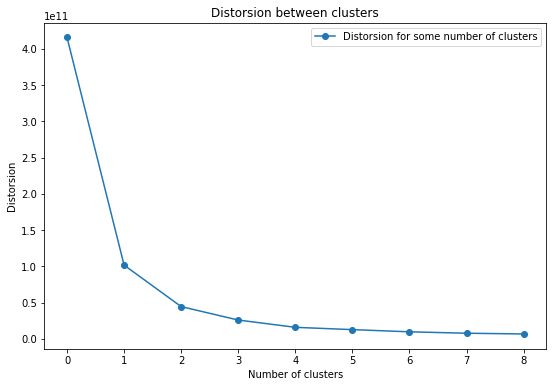

In [20]:
# במקום שנבחר מספר קבוצות שרירותי, נבחר את מספר הקבוצות המיטבי ע"פ שיטת המרפק
cluster_distorsion = []
for i in range(1, 10):
    test_sklearn = KMeans(n_clusters=i)
    test_sklearn.fit(reduced_features)
    cluster_distorsion.append(test_sklearn.inertia_)
plt.figure(figsize=(9, 6))
plt.plot(cluster_distorsion, marker='o', label='Distorsion for some number of clusters')
plt.title("Distorsion between clusters")
plt.xlabel('Number of clusters')
plt.ylabel("Distorsion")
plt.legend()
plt.show()

In [21]:
# ניתן לראות שהחלוקה לקבוצות משמעותית עד 2 ואולי 3 קבוצות. נבחר לחלק ל3 קבוצות
km = KMeans(n_clusters=3)
clusters = km.fit(reduced_features)

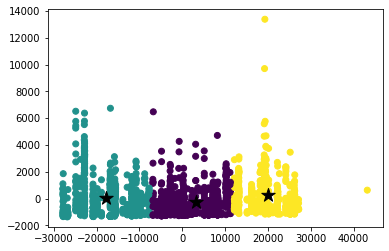

In [22]:
cluster_groups=list(clusters.labels_)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_groups, label=cluster_groups)
plt.scatter(clusters.cluster_centers_[:, 0], clusters.cluster_centers_[:, 1], marker='*', s=200, color='black', label='Centroids')
plt.show()

In [23]:
# חיבור התוצאה שקיבלנו לדאטה המקורי, ובעצם קבלה של עמודה חדשה שמסווגת ל3 קבוצות
facilities['clusters'] = clusters.labels_
facilities

,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,capacity,capacity_nan,lng_round,lat_round,clusters
0,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.009015,32.904507,188.0,237,77,0,17,0.0,0.79,0.79,-85,35,1
1,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.624068,33.180755,272.0,274,11,1,2,0.0,0.99,0.99,-85,35,1
2,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.162781,32.920754,1725.0,1835,164,3,61,0.0,0.94,0.94,-85,35,1
3,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.808344,33.531101,192.0,533,17,0,28,0.0,0.36,0.36,-85,35,1
4,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.673927,32.147144,1477.0,1588,162,5,80,1.0,0.93,0.93,-85,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,15289545,North Lake federal prison,Federal prison,Baldwin,Lake,26085,Michigan,-85.839287,43.928551,1614.0,1614,125,2,0,0.0,1.00,1.00,-85,45,0
2635,1558C2BF,Rivers federal prison,Federal prison,Winton,Hertford,37091,North Carolina,-76.958751,36.403668,6.0,1255,68,1,0,0.0,0.00,0.00,-75,35,0
2636,C9CF62B9,Reeves County federal prison,Federal prison,Pecos,Reeves,48389,Texas,-103.493817,31.423563,1005.0,1104,46,1,0,0.0,0.91,0.91,-105,30,2
2637,364869B9,Flightline federal prison,Federal prison,Big Spring,Howard,48227,Texas,-101.521236,32.224310,1652.0,1898,34,1,0,0.0,0.87,0.87,-100,30,2


In [ ]:
mydata = pd.read_csv("C:/Users/Moti/Desktop/after_clean.csv")
mydata2 = pd.read_csv("C:/Users/Moti/Desktop/prison-facilities_Corona.csv")
mydata3 = pd.read_csv("C:/Users/Moti/Desktop/itay_zaga.csv")

mydata = mydata.drop(columns = ['nyt_id' , 'facility_county_fips'])
mydata3 = mydata3.drop(columns = ['nyt_id' , 'facility_county_fips'])

# יש עדיין שורות עם נאלים. אני זורק אותן
mydata = mydata.dropna(subset = mydata.columns[:-2].values)



# add relevant features
mydata['ratio_cases_inmate'] = mydata['total_inmate_cases'] / mydata['max_inmate_population_2020']
mydata['ratio_deaths_inmate'] = mydata['total_inmate_deaths'] / mydata['max_inmate_population_2020']
mydata['ratio_cases_officer'] = mydata['total_officer_cases'] / mydata['max_inmate_population_2020']
mydata['ratio_deaths_officer'] = mydata['total_officer_deaths'] / mydata['max_inmate_population_2020']

mydata_convert = mydata.copy()

# histogram for every feature
for i in mydata.drop(columns = ['capacity' , 'capacity_nan']).columns.values:
    print(i , ':')
    plt.gcf().set_size_inches(60 ,5)
    plt.hist(mydata[i])
    plt.show()


# kolmodorov smirnov test for some features

# stats.kstest(mydata['facility_type'].value_counts().values, 'expon')    
# stats.kstest(mydata['facility_type'].value_counts().values, 'norm')

#stats.kstest(mydata['facility_city'].value_counts().values, 'expon')    
#stats.kstest(mydata['facility_city'].value_counts().values, 'norm')
#stats.kstest(mydata['facility_city'].value_counts().values, 'uniform')
    
# stats.kstest(mydata['facility_county'].value_counts().values, 'expon')    
# stats.kstest(mydata['facility_county'].value_counts().values, 'norm')
# stats.kstest(mydata['facility_county'].value_counts().values, 'uniform')
    
# stats.kstest(mydata['facility_state'].value_counts().values, 'expon')    
# stats.kstest(mydata['facility_state'].value_counts().values, 'norm')
# stats.kstest(mydata['facility_state'].value_counts().values, 'uniform')


mydata[mydata['ratio_cases_inmate'] > 5]['ratio_cases_inmate']
mydata.loc[1252,:]
mydata.loc[260,:]

mydata[mydata['ratio_cases_officer'] > 5]['ratio_cases_officer']
mydata.loc[518,:]



###########################################
# convert nominal to categorial

#check the range for facility lat
plt.gcf().set_size_inches(10 ,5)
plt.hist(mydata['facility_lat'])
plt.show()

(mydata[(mydata['facility_lat'] > 25) & (mydata['facility_lat'] < 35)]['facility_lat'] > 34 ).sum()

#18 - 25
#25 - 35
#35 - 45
#45 - 50
#50 - up


#facility lng
plt.hist(mydata['facility_lng'])
plt.show()

mydata[mydata['facility_lng'] < -125]['facility_lng']
mydata['facility_lng'].min()
#-165.4 - -125

mydata[(mydata['facility_lng'] > -125) & (mydata['facility_lng'] < -100)]['facility_lng']
#-125 - -100

mydata[(mydata['facility_lng'] > -100) & (mydata['facility_lng'] < -80)]['facility_lng']
#-100 - -80

mydata['facility_lng'].max()
#-80 - -66.1


#fuctions for convertion the values
def lat (num):
    if num < 25:
        return '15 - 25'
    elif num < 35:
        return '25 - 35'
    elif num < 45:
        return '35 - 45'
    elif num < 50:
        return '45 - 50'
    else:
        return '50 - 65'
    
def lng (num):
    if num < -125:
        return '-165 _ -125'
    elif num < -100:
        return '-125 _ -100'
    elif num < -80:
        return '-100 _ -80'
    else:
        return '-80 _ -66'
    
mydata_convert['facility_lat'] = mydata_convert['facility_lat'].apply(lat)
mydata_convert['facility_lng'] = mydata_convert['facility_lng'].apply(lng)


#latest inmate population
plt.hist(mydata['latest_inmate_population'])
plt.show()

#max_inmate_population_2020
plt.hist(mydata['max_inmate_population_2020'])
plt.show()

#total_inmate_cases
plt.hist(mydata['total_inmate_cases'])
plt.show()

#total_inmate_deaths
plt.hist(mydata['total_inmate_deaths'])
plt.show()

#total_officer_cases
plt.hist(mydata['total_officer_cases'])
plt.show()

#total_officer_deaths
plt.hist(mydata['total_officer_deaths'])
plt.show()


def latest_max (num):
    if num < 1000:
        return '0 - 1000'
    elif num < 2000:
        return '1000 - 2000'
    elif num < 3000:
        return '2000 - 3000'
    elif num < 4000:
        return '3000 - 4000'
    else:
        return '4000 - up'

    
def total_cases (num):
    if num < 400:
        return '0 - 400'
    elif num < 800:
        return '400 - 800'
    elif num < 1200:
        return '800 - 1200'
    elif num < 1500:
        return '1200 - 1500'
    else:
        return '1500 - up'

    
def total_deaths (num):
    if num < 5:
        return '0 _ 5'
    elif num < 10:
        return '5 _ 10'
    elif num < 15:
        return '10 _ 15'
    else:
        return '15 _ up'

    
def total_cases_officer (num):
    if num < 100:
        return '0 - 100'
    elif num < 220:
        return '100 - 220'
    elif num < 380:
        return '220 - 380'
    else:
        return '380 - up'

    
def total_deaths_officer (num):
    if num == 0:
        return '0'
    elif num == 1:
        return '1'
    elif num == 2:
        return '2'
    else:
        return '3 - up'

mydata_convert['latest_inmate_population'] = mydata['latest_inmate_population'].apply(latest_max)
mydata_convert['max_inmate_population_2020'] = mydata['max_inmate_population_2020'].apply(latest_max)
mydata_convert['total_inmate_cases'] = mydata['total_inmate_cases'].apply(total_cases)
mydata_convert['total_inmate_deaths'] = mydata['total_inmate_deaths'].apply(total_deaths)
mydata_convert['total_officer_cases'] = mydata['total_officer_cases'].apply(total_cases_officer)
mydata_convert['total_officer_deaths'] = mydata['total_officer_deaths'].apply(total_deaths_officer)


#ratio_cases_inmate
plt.hist(mydata['ratio_cases_inmate'] , bins = np.arange(0 , 3 , 0.05))
plt.show()

#ratio_deaths_inmate
plt.hist(mydata['ratio_deaths_inmate'] , range = (0.0001,0.05))
plt.show()

#ratio_cases_officer
plt.hist(mydata['ratio_cases_officer'] , range = (0.001 , 1))
plt.show()

#ratio_deaths_officer
plt.hist(mydata['ratio_deaths_officer'] , range = (0.0001 , 0.003))
plt.show()



def ratio_inmate_cases (num):
    if num < 0.2:
        return '0 - 0.2'
    elif num < 0.4:
        return '0.2 - 0.4'
    elif num < 0.6:
        return '0.4 - 0.6'
    elif num < 0.8:
        return '0.6 - 0.8'
    elif num < 1:
        return '0.8 - 1'
    else:
        return '1 - up'

def ratio_inmate_deaths (num):
    if num == 0.0:
        return '0'
    elif num < 0.001:
        return '0.0 - 0.001'
    elif num < 0.002:
        return '0.001 - 0.002'
    else:
        return '0.002 - up'


def ratio_officer_cases (num):
    if num == 0.0:
        return '0'
    elif num < 0.1:
        return '0.0 - 0.1'
    elif num < 0.2:
        return '0.1 - 0.2'
    elif num < 0.3:
        return '0.2 - 0.3'
    elif num < 0.6:
        return '0.3 - 0.6'
    else:
        return '0.6 - up'

    
def ratio_officer_deaths (num):
    if num == 0.0:
        return '0'
    elif num < 0.0005:
        return '0.0 - 0.0005'
    elif num < 0.001:
        return '0.0005 - 0.001'
    elif num < 0.002:
        return '0.001 - 0.002'
    elif num < 0.003:
        return '0.002 - 0.003'
    else:
        return '0.003 - up'

    
mydata_convert['ratio_cases_inmate'] = mydata['ratio_cases_inmate'].apply(ratio_inmate_cases)
mydata_convert['ratio_deaths_inmate'] = mydata['ratio_deaths_inmate'].apply(ratio_inmate_deaths)
mydata_convert['ratio_cases_officer'] = mydata['ratio_cases_officer'].apply(ratio_officer_cases)
mydata_convert['ratio_deaths_officer'] = mydata['ratio_deaths_officer'].apply(ratio_officer_deaths)






# make confusion_matrix for every deuce variables
for i in mydata_convert.drop(columns = ['capacity' , 'capacity_nan']).columns.values:
    a = pd.DataFrame(mydata_convert.drop(columns = ['capacity' , 'capacity_nan']).columns)
    a = (a[(a == i).to_numpy()].index[0]) + 1
    for j in mydata_convert.drop(columns = ['capacity' , 'capacity_nan']).columns[7:].values:
        if i != j:
            print('confusion_matrix for ' , i , ' and ' , j , ':')
            print(pd.crosstab(index = mydata_convert[i] , columns = mydata_convert[j]))

# check correlations between every deuce variables
for i in mydata_convert.drop(columns = ['capacity' , 'capacity_nan']).columns.values:
    a = pd.DataFrame(mydata_convert.drop(columns = ['capacity' , 'capacity_nan']).columns)
    a = (a[(a == i).to_numpy()].index[0]) + 1
    for j in mydata_convert.drop(columns = ['capacity' , 'capacity_nan']).columns[a:].values:
        print('p values of chei test for ' , i , ' and ' , j , ':')
        b = pd.crosstab(index = mydata_convert[i] , columns = mydata_convert[j])
        b = chi2_contingency(b , correction = False)
        print(b[1] , '\n')
print(mydata.iloc[: , 7:13].corr())